# 文本卷积

## 基本文本卷积

- For more information, refer to:
    - [Kim 2014](http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf)
    - [Zhang et al 2015](https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)

- 使用卷积进行句子分类(Kim 2014)
![text_cnn](images/text_conv_1.png)

- 多个卷积核
![text_cnn](images/text_conv_2.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
num_features = 3000
sequence_length = 300
embedding_dimension = 100

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_features)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [4]:
x_train = pad_sequences(x_train, maxlen=sequence_length)
x_test = pad_sequences(x_test, maxlen=sequence_length)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000, 300)
(25000, 300)
(25000,)
(25000,)


## 构造基本句子分类器

In [5]:
def imdb_cnn():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,input_length=sequence_length),
        layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid'),
        layers.MaxPool1D(2, padding='valid'),
        layers.Flatten(),  # 将输入展平。不影响批量大小
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    
    return model

In [6]:
model = imdb_cnn()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 50)           25050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7400)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                74010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 399,071


In [7]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
22500/22500 [==============================] - 26s 1ms/sample - loss: 0.4747 - acc: 0.7337 - val_loss: 0.3102 - val_acc: 0.8692
Epoch 2/5
22500/22500 [==============================] - 25s 1ms/sample - loss: 0.2437 - acc: 0.9024 - val_loss: 0.2988 - val_acc: 0.8760
Epoch 3/5
22500/22500 [==============================] - 25s 1ms/sample - loss: 0.1289 - acc: 0.9531 - val_loss: 0.3472 - val_acc: 0.8644
Epoch 4/5
22500/22500 [==============================] - 26s 1ms/sample - loss: 0.0302 - acc: 0.9933 - val_loss: 0.4949 - val_acc: 0.8672
Epoch 5/5
22500/22500 [==============================] - 25s 1ms/sample - loss: 0.0049 - acc: 0.9995 - val_loss: 0.5516 - val_acc: 0.8620
CPU times: user 5min 19s, sys: 46.1 s, total: 6min 5s
Wall time: 2min 7s


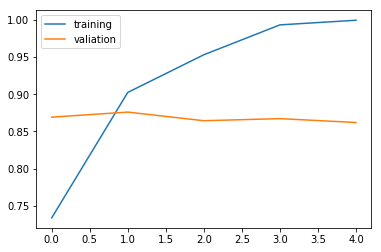

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

## 多核卷积网络

In [10]:
filter_sizes=[3,4,5]

def convolution():
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(filters=64, kernel_size=(size, embedding_dimension),
                            strides=1, padding='valid', activation='relu')(inn)
        pool = layers.MaxPool2D(pool_size=(sequence_length-size+1, 1), padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)
    
    model = keras.Model(inputs=inn, outputs=outt)
    
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,
                        input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
        
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    
    return model

In [11]:
model = cnn_mulfilter()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape (Reshape)            (None, 300, 100, 1)       0         
_________________________________________________________________
model (Model)                (None, 1, 1, 192)         76992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1930      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
___________________________

In [12]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 85s 4ms/sample - loss: 0.4648 - acc: 0.7714 - val_loss: 0.3126 - val_acc: 0.8692
Epoch 2/5
22500/22500 [==============================] - 84s 4ms/sample - loss: 0.2757 - acc: 0.8930 - val_loss: 0.2702 - val_acc: 0.8940
Epoch 3/5
22500/22500 [==============================] - 85s 4ms/sample - loss: 0.2030 - acc: 0.9288 - val_loss: 0.2734 - val_acc: 0.8940
Epoch 4/5
22500/22500 [==============================] - 84s 4ms/sample - loss: 0.1450 - acc: 0.9536 - val_loss: 0.3019 - val_acc: 0.8968
Epoch 5/5
22500/22500 [==============================] - 84s 4ms/sample - loss: 0.0980 - acc: 0.9728 - val_loss: 0.3504 - val_acc: 0.8972
CPU times: user 21min 47s, sys: 2min 33s, total: 24min 21s
Wall time: 7min 2s


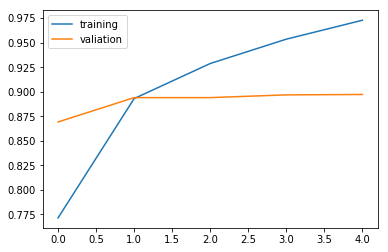

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()